# Retention Rate Analysis of the Users Cohorts
---
In this section, we visualize users activity based on their retention, look at their retention rates for two traffic sources, and analyze the quality of the users brought by the recent ads campaign.  
We also try to understand what caused the recent drop in active users.

## Summary and Conclusion:
- The incoming users level during the last weeks stays almost constant at 10 000 users per week, yet earlier weeks showed influx at around 15 000 users.   
We may try to advertise our product better to increase the flow of the newcomers.

- Retained users (our most valuable ones) are growing in the beginning and stop growing at about 50 000 per week.  
- Leaving users are still growing though, reaching 30 000 users per week at a peak - may be worth having a look what can be done to retain these users.
- Ads-sourced users are on average less retained (e.g. 16% vs 10%) than organic users.
- Recent ads campaign brought users with quite low retention (2% vs 12% in control), yet their general activity was higher than for normally-sourced users. 
Given the cost of their acqusition, we can plan how to retain better these campaign-sourced users to enhance users engagement in future.
- The recent drop in DAU was not caused by OS-specific bugs or subscription issues and likely was caused by the regional problems in data centers.

## Major steps:

### 1. Active Users - New, Retained, Lost
How many new users are coming every week? How many users do we have from our 'core'? How many are we losing every week?

### 2. User Retention by Traffic Type
How different are users from paid VS organic traffic in their retention?

### 3. Ad Campaign - Effect on Retention
How good are the users attracted by the recent marketing campaign?

### 4. Drop in the DAU - Troubleshooting
What is common for the users who could not enter the feed and caused the drop in DAU? 

### Table of Contents
- [Imports, functions, global parameters](#section-0): set the environment

- [Active Users - New, Retained, Lost](#section-1): classify the users and plot their number
- [User Retention Rate by Traffic Type](#section-2)
- [Ad Campaign - Effect on Retention](#section-3): compare the retention rates
- [Drop in the DAU - Troubleshooting](#section-4): compare the features of the users


<a class="anchor" id="section-0"></a>
### Imports, functions, global parameters

#### Imports

In [77]:
# to hide a database access password
import os
from dotenv import load_dotenv

# suppress pallette-related matplotlib warnings
import warnings 

# data work
import numpy as np
import pandas as pd
import swifter # use .apply in pandas quicker

# database connection - modification of the original pandahouse package
import pandahouse_connector as ph

# visualization
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import seaborn as sns

#### Parameters

In [3]:
# Load environment variables from .env file
load_dotenv(dotenv_path='../.env')

# introduce the secret variable to connect to the db
DA_SL_PWD = os.environ.get('DA_SL_PWD')

# set the connection with the db
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'database':'simulator_20230720',
    'user':'student', 
    'password':DA_SL_PWD
    }

# define the name of the schema
feed_db = 'simulator_20230720.feed_actions'

In [4]:
# suppress pallette-related matplotlib warnings
warnings.filterwarnings('ignore', category=UserWarning)

#### Functions

In [25]:
# Create a function that plots a retention heatmap on a given grid
def heatmapper(
    table: pd.DataFrame, 
    ax: axes._axes.Axes,
    title: str = None,
    xlabel: str = None,
    ylabel: str = None
    ) -> None:
    """
    Plots a heatmap for the given pivot table (table) on the given axis (ax)
    """
    
    # Check the label values and infer those not set from the table:
    if not ylabel:
        ylabel = table.columns.name
    if not xlabel:
        xlabel = table.index.name
    if not title:
        title = f"{ylabel} vs {xlabel}"
        
    # Plot the heatmap of the retention of ad-sourced users
    sns.heatmap(table, annot=True, cmap='coolwarm', fmt='.0f', cbar=False, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=0)

In [73]:
# Create a function that plots a lineplot on a given grid
def lineplotter(
    data: pd.DataFrame,
    x: str,
    y: str,
    ax: axes._axes.Axes,
    hue: str = None,
    title: str = None,
    xlabel: str = None,
    ylabel: str = None
    ) -> None:
    """
    Plots a lineplot for the given dataframe (table) on the given axis (ax)
    """
    
    # Check the label values and infer those not set from the table:
    if not ylabel:
        ylabel = y
    if not xlabel:
        xlabel = x
    if not title:
        title = f"{ylabel} vs {xlabel}"
        
    # Plot the heatmap of the retention of ad-sourced users
    sns.lineplot(
        data=user_amount_with_metrics,
        x=x, 
        y=y, 
        hue=hue,
        marker='o', 
        ax=ax,
        markersize=5, 
        linewidth=1
    )
    
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=0)

In [81]:
# create a function that would build bar plots and shorten these tediously long lines!
def barplotter(
    data, 
    title,
    xlabel, 
    ylabel, 
    ax, 
    stacked=False
):
    """
    Build a bar plot using the provided data, title, xlabel, ylabel, and ax instance.

    Parameters:
        data (pd.Series): The data to plot (Pandas Series).
        title (str): The title of the plot.
        xlabel (str): The label for the X-axis.
        ylabel (str): The label for the Y-axis.
        ax (matplotlib.axes._subplots.AxesSubplot): The AxesSubplot instance to plot on.
        stacked (bool, optional): Whether to stack the bars (default is False).

    Returns:
        None
    """
    
    if stacked:
        data = data.unstack()

    # Plot the data as a bar plot on the given ax
    data.plot(kind="bar", ax=ax, stacked=stacked, rot=0)

    # Set the title, xlabel, and ylabel
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Set the tick labels font size for both X and Y axes
    ax.tick_params(axis='both', which='major')

    # Rotate xtick labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


### 1. Active Users - New, Retained, Lost <a class="anchor" id="section-1"></a>

Before we start, let's see how many users of every class we have weekly:
  - Those joined this week (new)
  
  - Those active both this and previous week (retained)
  - Those active previous week but not this one (lost)

Let's first get aggregated data we need for visuzalization

In [8]:
# get a table where for each week we have amount of:
# 1. new users;
# 2. users active this and previous week;
# 3. users active previous, but not this week.
query = '''
-- table where for every unique pair user-active week, 
-- shows if this user joined that week, was active last week, and was active next week
WITH weeks_labeled AS (
SELECT 
user_id, 
week, 
all_weeks,
start_week,
if(has(all_weeks, week - 7), 1, 0) AS is_previous_week,
if(has(all_weeks, week + 7), 1, 0) AS is_next_week

FROM

-- table showing all user activity weeks aggregated into an array
(SELECT DISTINCT user_id, 
toStartOfWeek(time) AS week, 
groupUniqArray(toStartOfWeek(time)) OVER (PARTITION BY user_id) AS all_weeks,
min(toStartOfWeek(time)) OVER (PARTITION BY user_id) AS start_week
FROM simulator_20230720.feed_actions) t1
)

SELECT toString(week) as week,
new_users,
retained_users,
lost_users

FROM 
-- table having counts for new and retained users by week
(SELECT 
week, 
countIf(week = start_week) AS new_users,
countIf(is_previous_week = 1) AS retained_users
FROM weeks_labeled
GROUP BY week
) with_retained

JOIN 

-- table having counts for users who didn`t come from last week.
-- basically, weeks are shifted one week up to align 
-- with is_next_week column to indicate how many users did not come ("gone")
(SELECT 
week + 7 AS to_next_week,
countIf(is_next_week = 0) * (-1) AS lost_users
FROM weeks_labeled
GROUP BY to_next_week
) with_gone

ON (with_retained.week = with_gone.to_next_week)
'''

# import a table to a dataframe
weeks_by_user_groups = ph.read_clickhouse(
    query, 
    connection=CONNECTION
)


In [9]:
# set the index - this simplifies plotting of the bar plot
weeks_by_user_groups.set_index('week', inplace=True)


In [10]:
weeks_by_user_groups.info()
weeks_by_user_groups.head(5)


<class 'pandas.core.frame.DataFrame'>
Index: 15 entries, 2023-06-04 to 2023-09-10
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   new_users       15 non-null     uint64
 1   retained_users  15 non-null     uint64
 2   lost_users      15 non-null     int64 
dtypes: int64(1), uint64(2)
memory usage: 480.0+ bytes


,new_users,retained_users,lost_users
week,,,
2023-06-04,11592,853,-25
2023-06-11,13438,11215,-1230
2023-06-18,14061,20281,-4393
2023-06-25,14861,26847,-8357
2023-07-02,13202,32189,-12208


Now plot the barplot, discard the last entry of the df to drop the last week from the observations

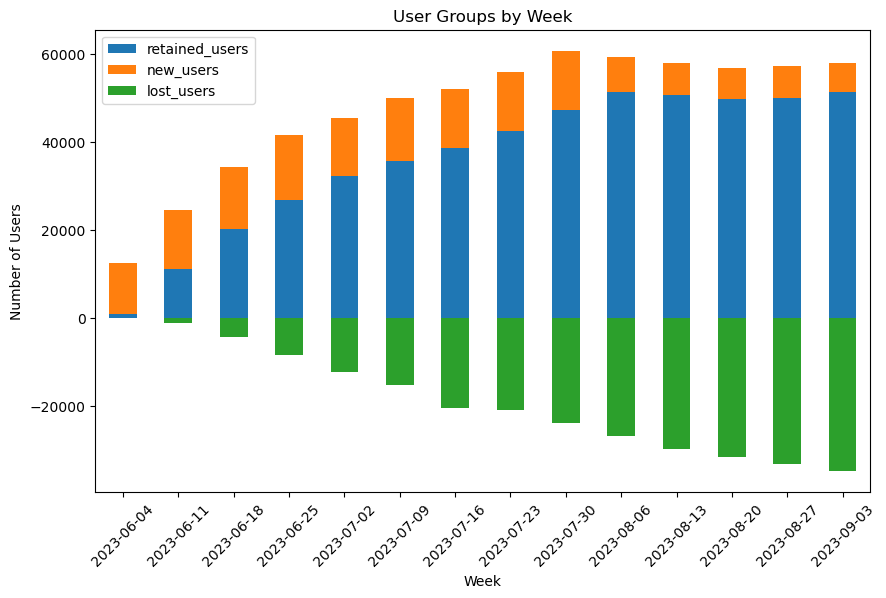

In [18]:
# make a canvas, set sizes
fig, ax = plt.subplots(figsize=(10, 6))

# create a bar plot
weeks_by_user_groups[['retained_users','new_users','lost_users']][:-1].plot.bar(ax=ax, stacked=True, rot=0)

# adjust fonts and ticks
ax.set_xlabel('Week')
ax.set_ylabel('Number of Users')
ax.set_title('User Groups by Week')

ax.tick_params(axis='y')
ax.tick_params(axis='x', rotation=45)

plt.show()


- The incoming users level during the last weeks stays almost constant at 10 000 users per week, yet earlier weeks showed influx at around 15 000 users.   
We may try to advertise our product better to increase the flow of the newcomers.

- Retained users (our most valuable ones) are growing in the beginning and stop growing at about 50 000 per week.  
- Leaving users are still growing though, reaching 30 000 users per week at a peak - may be worth having a look what can be done to retain these users.

Let's look at these groups in more detail: does retention pattern differ between users who came to the feed via different sources?

### 2. User Retention Rate by Traffic Type <a class="anchor" id="section-2"></a>
---

In our news feed usage data, there are two types of users: those who came through paid traffic with the source 'ads', and those who came through "organic" channels with the source 'organic'.

Our goal is to analyze and compare the retention rate of these two groups.   

We should answer the question: **does the usage behavior of the app differ between these groups of users?**

Questions: 
1. How does retention look for these two groups?

2. Is retention pattern different between these two groups?

Steps to do:

1. Get a table: 
  - start_day: day of start using the feed, 
  
  - day: day, 
  - ads_users: amount of unique users who came via ads and started using the product on start_day and use it on the day = day,
  - organic_users: same but organic users,
  - ads_users_percentage: metric normalized to the amount of the users at the start_day,
  - organic_users_percentage: same,
  - organic_users_percentage - ads_users_percentage: difference between two percentages.
     
2. Plot Retention over time (heatmaps) for these two groups - do visual comparison

3. Plor heatmap of organic_users_percentage - ads_users_percentage
4. Choose a starting day and period to compare retention rate of the groups

Again, starting with querying

In [19]:
# first, query a dataframe
# where number of active users by source group is aggregated
# across the day and the starting day of the users
query = '''
WITH retained_users AS (
SELECT *
   FROM
     (SELECT user_id,
             min(toDate(time)) AS start_day
      FROM {db}.feed_actions
      GROUP BY user_id) t1
   JOIN
     (SELECT DISTINCT user_id,
                      gender,
                       multiIf(age <= 16, '0-15', age > 16 and age <= 30, '16-30', age > 30 and age <= 55, '30-55', '55+') AS age_group,
                       os,
                       source,
                      toDate(time) AS day
      FROM {db}.feed_actions) t2 USING user_id
   WHERE (start_day BETWEEN '2023-07-02'::DATE AND '2023-07-20'::DATE) AND (day < '2023-07-24'::DATE)
),

retained_users_by_date_source AS (

SELECT toString(start_day) start_day,
       toString(day) day,
                     countIf(user_id, source = 'ads') AS users_ads,
                     countIf(user_id, source = 'organic') AS users_organic,
                     count(user_id) AS users
FROM retained_users
GROUP BY start_day,
         day
)

SELECT start_day,
day,
users_ads,
MAX(users_ads) OVER (PARTITION BY start_day) AS users_ads_start,
users_organic,
MAX(users_organic) OVER (PARTITION BY start_day) AS users_organic_start
FROM retained_users_by_date_source
'''

# import the table to a dataframe; convert number of user to float
# to calculate percentage of users relative to their start day
# at the next steps
users_by_day_source = ph.read_clickhouse(
    query, 
    connection=CONNECTION
).astype(
    dtype={'users_ads_start': 'float', 'users_organic_start': 'float'}
) 


In [21]:
users_by_day_source.info()
users_by_day_source.head(2)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247 entries, 0 to 246
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   start_day            247 non-null    object 
 1   day                  247 non-null    object 
 2   users_ads            247 non-null    uint64 
 3   users_ads_start      247 non-null    float64
 4   users_organic        247 non-null    uint64 
 5   users_organic_start  247 non-null    float64
dtypes: float64(2), object(2), uint64(2)
memory usage: 11.7+ KB


,start_day,day,users_ads,users_ads_start,users_organic,users_organic_start
0,2023-07-02,2023-07-19,163,1247.0,212,1076.0
1,2023-07-02,2023-07-06,437,1247.0,428,1076.0


Now set new columns with percentages  - divide the amount of users by the amount at their starting day

In [22]:
users_by_day_source['retained_percentage_ads'] = users_by_day_source['users_ads'].div(users_by_day_source['users_ads_start']).mul(100)
users_by_day_source['retained_percentage_organic'] = users_by_day_source['users_organic'].div(users_by_day_source['users_organic_start']).mul(100)

users_by_day_source.head(2)

,start_day,day,users_ads,users_ads_start,users_organic,users_organic_start,retained_percentage_ads,retained_percentage_organic
0,2023-07-02,2023-07-19,163,1247.0,212,1076.0,13.071371,19.702602
1,2023-07-02,2023-07-06,437,1247.0,428,1076.0,35.044106,39.776952


For the two types of traffic, plot retention heatmaps back to backs

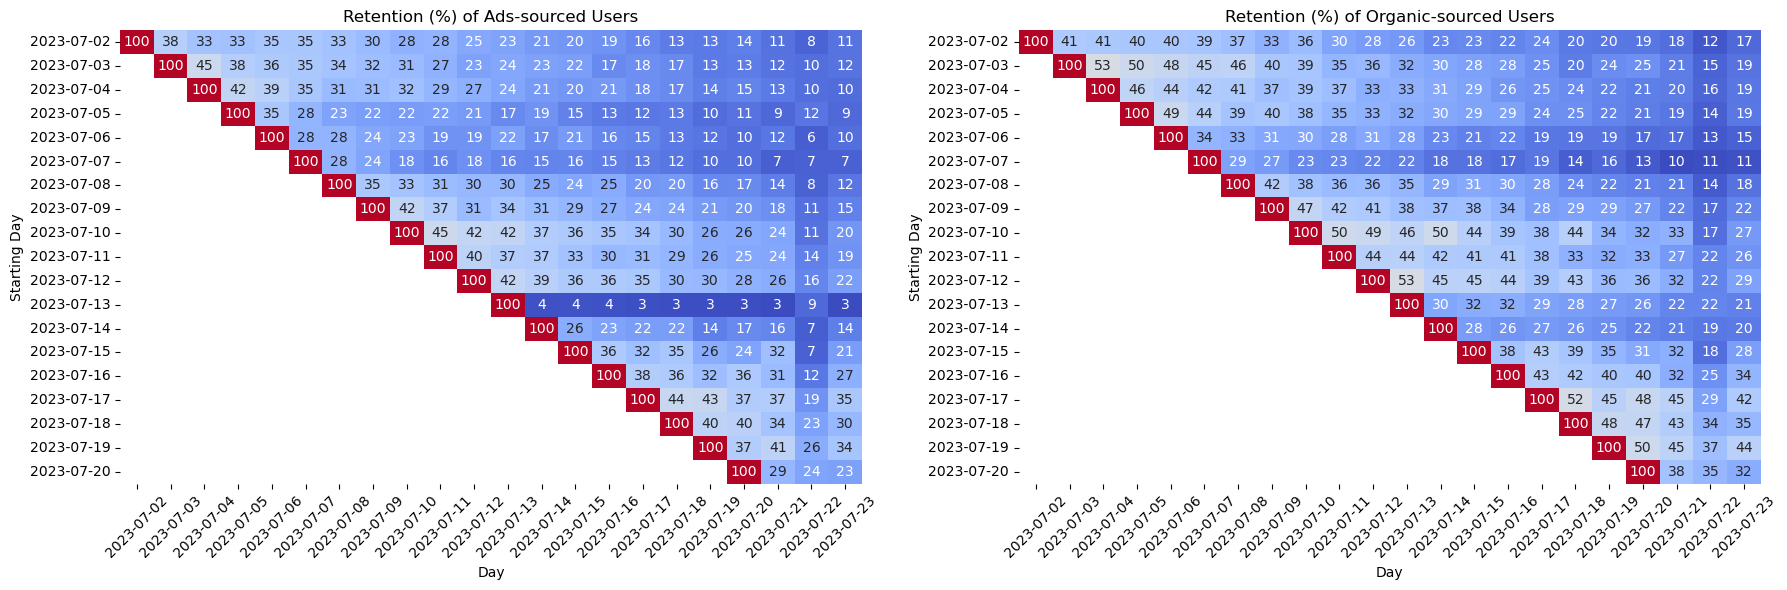

In [30]:
# create a canvas
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Create pivot tables to reshape the data
pivot_table_ads = users_by_day_source.pivot_table(index='start_day', columns='day', values='retained_percentage_ads')
pivot_table_organic = users_by_day_source.pivot_table(index='start_day', columns='day', values='retained_percentage_organic')

for ax, source, table in zip(axs, ['Ads', 'Organic'], [pivot_table_ads, pivot_table_organic]):
    
    # Plot the corresponding map
    heatmapper(
        table, 
       ax=ax, 
       title=f'Retention (%) of {source}-sourced Users', 
       xlabel='Day',
       ylabel='Starting Day'
    )

plt.tight_layout(w_pad=2)


By eye, there is not much of a difference: ads-sourced users coming on **13 July** are less retained than organic-sourced ones. Apart from that, it's hard to see the difference.   
Let's plot the heatmap of the difference in the retention rate (%) between organic and ads-sourced users. 

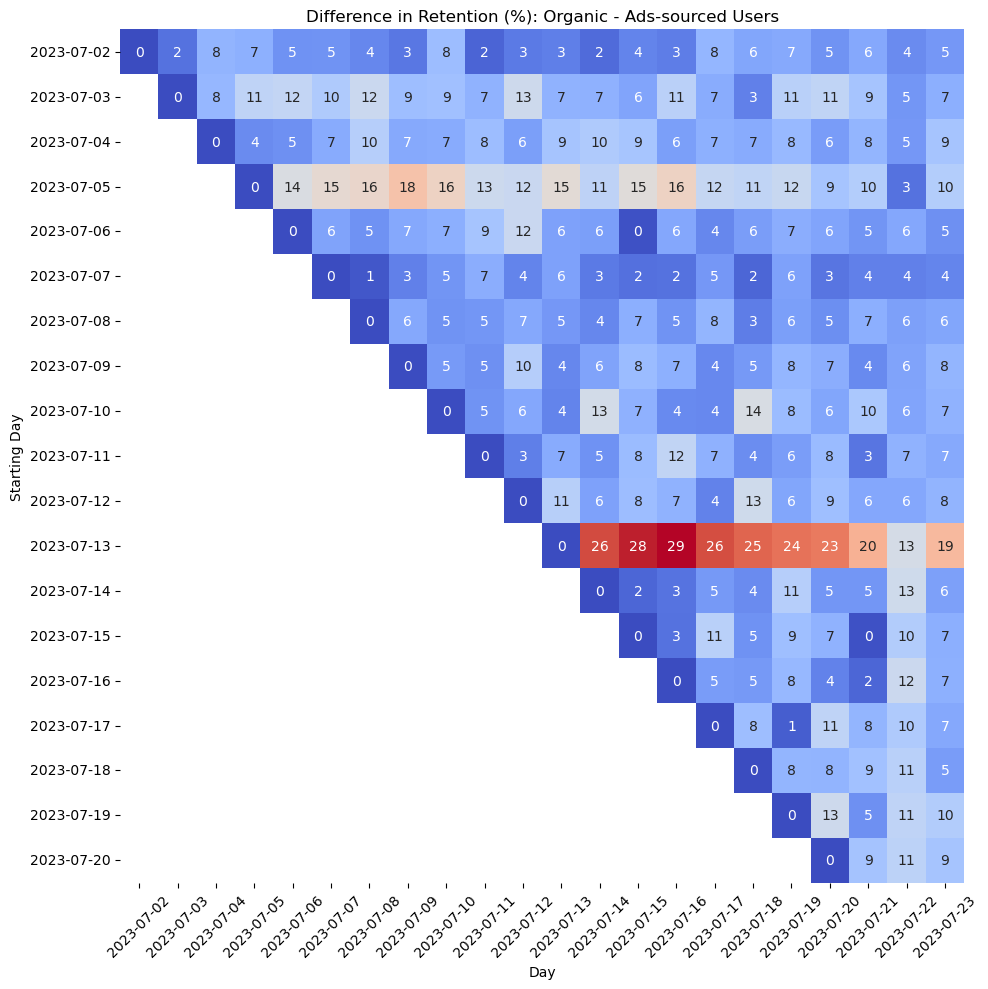

In [37]:
# create a new columns with the difference
users_by_day_source['organic_subtracted_ads'] = users_by_day_source['retained_percentage_organic'].sub(users_by_day_source['retained_percentage_ads'])

# Create a pivot table to reshape the data
pivot_table_delta = users_by_day_source.pivot_table(index='start_day', columns='day', values='organic_subtracted_ads')

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the map
heatmapper(
    pivot_table_delta, 
    ax=ax, 
    title='Difference in Retention (%): Organic - Ads-sourced Users', 
    xlabel='Day',
    ylabel='Starting Day'
)
plt.tight_layout()

In general, retention is better in organic-sourced users (difference is always positive in this heatmap) - makes sense, as it is harder to keep a user joined via ad campaign!  
There are 3 cohorts where the difference is the biggest:
1. 13 July - Big ad campaign was carried out.
2. 5 July - Can be related to AB test carried out at the time.
3. 3 July - not that strong but different from other cohorts.

For the rest, the difference is not that strong.  

Knowing this is quite important for our unit economics - it is possible to combine the cost of acqusition of a user for each traffic type, their average retention, and CTR, to have an idea if the paid traffic works well enough.  

Now, let's take a "usual" week where the weekly averaged difference in retention is close to the median value and compare RR between the groups.

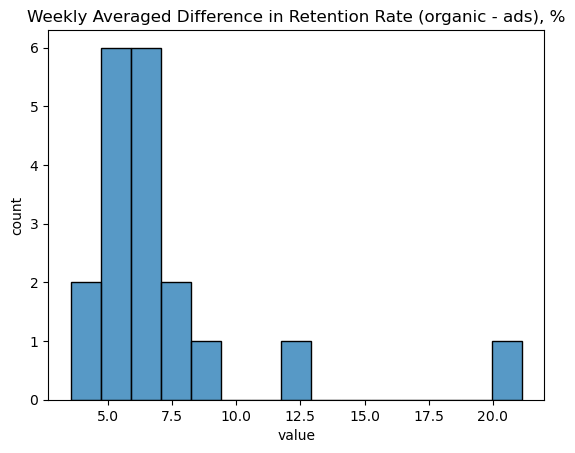

In [41]:
# look at how the weekly averaged difference of RR (%) is distributed
# across the weeks
fig, ax = plt.subplots()

sns.histplot(pivot_table_delta.mean(axis=1), ax=ax)
ax.set_title('Weekly Averaged Difference in Retention Rate (organic - ads), %')
ax.set_xlabel('value')
ax.set_ylabel('count')

plt.show()


Let's take 6 July as a start date (its mean RR difference lies at the median of the RR% distribution) and compare 2-week retention rate for the groups.

In [86]:
# make a filter to take rows with users started on 6 July and their count on 6 and 20 July
condition = (users_by_day_source.start_day == '2023-07-06') & users_by_day_source.day.isin(['2023-07-06', '2023-07-20'])

# create a dataframe with the filter and calculate ratio of users at the end of 2-week period
# to the start of the period
users_after_2_weeks = users_by_day_source.loc[condition][['day', 'users_ads', 'users_organic']]
users_after_2_weeks = users_after_2_weeks.set_index(['day']).T
users_after_2_weeks.rename(columns={'2023-07-06': 'at_start_day', '2023-07-20': 'at_2_weeks'}, inplace=True)

users_after_2_weeks['as_percent_after_2_weeks'] = users_after_2_weeks.iloc[:, 1].div(users_after_2_weeks.iloc[:, 0]).mul(100)

users_after_2_weeks


day,at_start_day,at_2_weeks,as_percent_after_2_weeks
users_ads,374,39,10.427807
users_organic,583,97,16.638079


On an average day (e.g., not campaign/AB-test/bug-related day), there is about 6% difference in retention!  
Ads-sourced users seem to be less connected with the product, which again makes sense.  



### 3. Ad Campaign - Effect on Retention <a class="anchor" id="section-3"></a>
---

Marketers launched a massive advertising campaign, which resulted in a significant influx of new users to the application, as seen from the spike in the active audience graph on **13 July**.  
However, we have doubts about the quality of the traffic.   
Let's investigate what happens to the ad-acquired users in the future and how often they continue using the application.

To do:
1. Look at the delta heatmap for RR between two sources - slice it for clarity so it starts week before the campaign (6 July).

2. Compare RR for Ads-sourced users - starting on the campagin day and those who came week before (control day) - any difference?
3. Compare unique views per user, likes per user, CTR - daily metrics for the campaign-sourced users and the control.

First, reate a pivot table (RR % difference) to reshape the data with starting days >= 1 week before the campaign

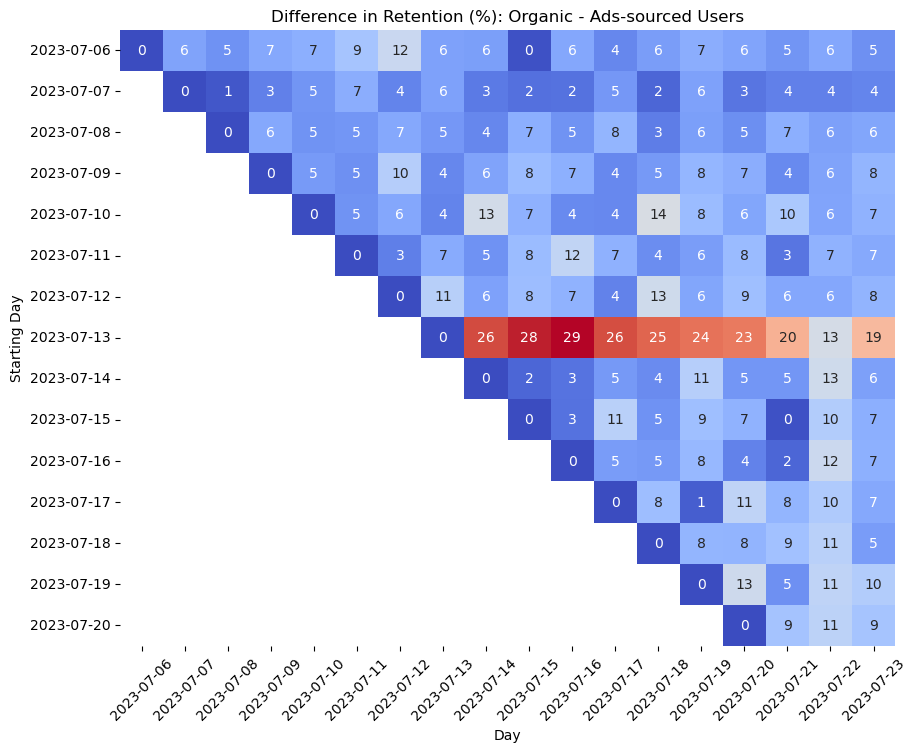

In [43]:
# canvas
fig, ax = plt.subplots(figsize=(10, 8))

# pivot table 
pivot_table_delta = users_by_day_source.loc[(users_by_day_source.start_day >= '2023-07-06')].pivot_table(index='start_day', columns='day', values='organic_subtracted_ads')

# Plot the map
heatmapper(
    pivot_table_delta, 
    ax=ax, 
    title='Difference in Retention (%): Organic - Ads-sourced Users', 
    xlabel='Day',
    ylabel='Starting Day'
)


Now look at the 1-week RR for ads-sourced users and compare those who came 13/7/23 (campaign) and 6/7/23 (control)

In [88]:
# convert dates from strings to datetime objects
users_by_day_source = users_by_day_source.astype(
    {'start_day': 'datetime64[ns]', 'day': 'datetime64[ns]'}
)

# Define the dates to filter
start_days = pd.to_datetime(['2023-07-06', '2023-07-13'])

# make a filter to select rows with 1 week offset with the start date
condition = (users_by_day_source['start_day'].isin(start_days)) & (users_by_day_source['day'] - users_by_day_source['start_day'] == pd.Timedelta(days=7))

# apply the filter
compare_rr_campaign = users_by_day_source.loc[condition, 
               ['day', 'start_day', 'users_ads', 'users_ads_start', 'retained_percentage_ads']].set_index('start_day')

compare_rr_campaign


,day,users_ads,users_ads_start,retained_percentage_ads
start_day,,,,
2023-07-06,2023-07-13,84,374.0,22.459893
2023-07-13,2023-07-20,75,2592.0,2.893519


- There is about 20% difference in retention (2 vs 22% for campaign vs control).

What about other metrics of these two groups? Look at unique views per user, likes per user, CTR.  
For this, we need a table: userid, start_day, day, users, likes, unique_views, ctr.

In [67]:
#3.  Get a table with daily metrics aggregated by day
# for users who started on 13 July (target) and 6 July (control)
# within 7 days from their start
query = '''
WITH retained_users AS (

SELECT *
   FROM
     (SELECT user_id,
             min(toDate(time)) AS start_day
      FROM {db}.feed_actions
      GROUP BY user_id) t1
   JOIN
     (SELECT user_id,
     countIf(user_id, action = 'like') AS likes,
     uniq(post_id) AS unique_views,
     countIf(user_id, action = 'view') AS views,
        toDate(time) AS day
      FROM {db}.feed_actions
      WHERE source = 'ads'
      GROUP BY user_id, day) t2 USING user_id
   -- WHERE start_day >= today() - 30 AND start_day != today() AND day != today()
   
),

retained_users_by_date_source AS (

SELECT start_day,
       day,
     COUNT(user_id) AS users_ads,
     SUM(likes) AS likes,
     SUM(unique_views) AS unique_views,
     SUM(views) AS views
     
FROM retained_users
WHERE start_day IN ('2023-07-06'::DATE, '2023-07-13'::DATE) AND (day - start_day <= 7)
GROUP BY start_day,
         day
)

SELECT toString(start_day) start_day,
toString(day) day,
users_ads,
MAX(users_ads) OVER (PARTITION BY start_day) AS users_ads_start,
likes,
likes::FLOAT / users_ads AS likes_per_user,
unique_views::FLOAT / users_ads AS views_per_user,
unique_views,
views,
likes::FLOAT / views AS CTR
FROM retained_users_by_date_source

'''

# import a table to a dataframe
user_amount_with_metrics = ph.read_clickhouse(
    query, 
    connection=CONNECTION
).astype(
    dtype={'users_ads_start': 'float'}
) 


In [68]:
user_amount_with_metrics.info()
user_amount_with_metrics.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   start_day        16 non-null     object 
 1   day              16 non-null     object 
 2   users_ads        16 non-null     uint64 
 3   users_ads_start  16 non-null     float64
 4   likes            16 non-null     uint64 
 5   likes_per_user   16 non-null     float64
 6   views_per_user   16 non-null     float64
 7   unique_views     16 non-null     uint64 
 8   views            16 non-null     uint64 
 9   CTR              16 non-null     float64
dtypes: float64(4), object(2), uint64(4)
memory usage: 1.4+ KB


,start_day,day,users_ads,users_ads_start,likes,likes_per_user,views_per_user,unique_views,views,CTR
0,2023-07-06,2023-07-12,70,374.0,462,6.600000,25.342857,1774,2162,0.213691
1,2023-07-06,2023-07-13,84,374.0,622,7.404762,29.202381,2453,2856,0.217787
2,2023-07-06,2023-07-09,91,374.0,544,5.978022,27.285714,2483,2899,0.187651
3,2023-07-06,2023-07-08,106,374.0,809,7.632075,31.839623,3375,4166,0.194191
4,2023-07-06,2023-07-07,105,374.0,774,7.371429,29.619048,3110,3711,0.208569


In [69]:
# make a better-looking "group" column
user_amount_with_metrics['group'] = user_amount_with_metrics['start_day'].swifter.apply(lambda x: 'non-campaign control' if x == '2023-07-06' else 'campaign-sourced')

# Convert 'start_day' and 'day' columns to datetime type
user_amount_with_metrics['start_day'] = pd.to_datetime(user_amount_with_metrics['start_day'])
user_amount_with_metrics['day'] = pd.to_datetime(user_amount_with_metrics['day'])

# set days to the same range by substracting the dates
user_amount_with_metrics['day_normalized'] = (user_amount_with_metrics['day'] - user_amount_with_metrics['start_day']).dt.days  # this converts the timedelta to integer days

# Convert 'start_day' column back to string
user_amount_with_metrics = user_amount_with_metrics.astype(
    dtype={'start_day': 'object'}
) 

Pandas Apply: 100%|██████████| 16/16 [00:00<00:00, 27719.48it/s]


In [71]:
user_amount_with_metrics.head(5)

,start_day,day,users_ads,users_ads_start,likes,likes_per_user,views_per_user,unique_views,views,CTR,group,day_normalized
0,2023-07-06 00:00:00,2023-07-12,70,374.0,462,6.600000,25.342857,1774,2162,0.213691,non-campaign control,6
1,2023-07-06 00:00:00,2023-07-13,84,374.0,622,7.404762,29.202381,2453,2856,0.217787,non-campaign control,7
2,2023-07-06 00:00:00,2023-07-09,91,374.0,544,5.978022,27.285714,2483,2899,0.187651,non-campaign control,3
3,2023-07-06 00:00:00,2023-07-08,106,374.0,809,7.632075,31.839623,3375,4166,0.194191,non-campaign control,2
4,2023-07-06 00:00:00,2023-07-07,105,374.0,774,7.371429,29.619048,3110,3711,0.208569,non-campaign control,1


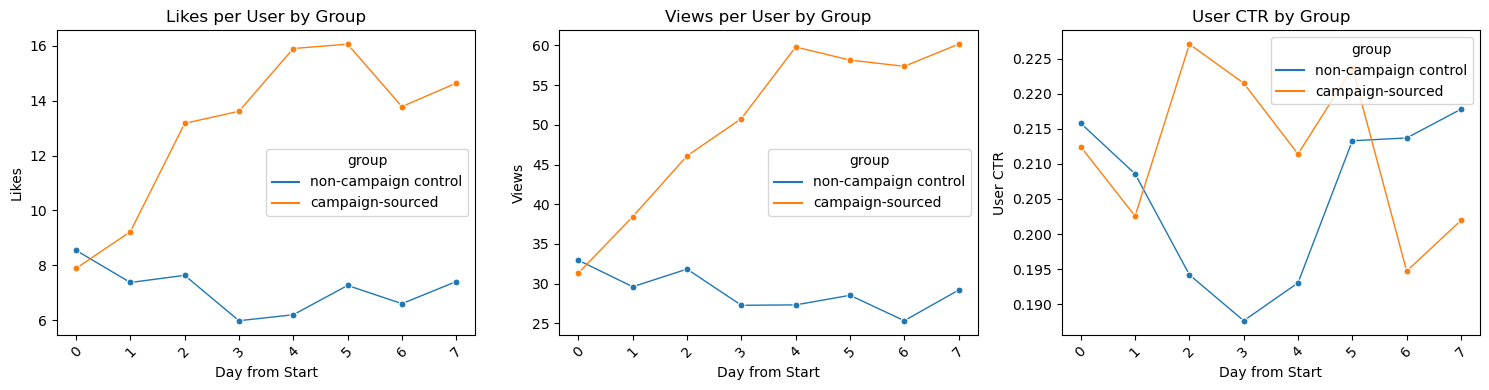

In [74]:
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# Define the data and related properties in lists
ys = ['likes_per_user', 'views_per_user', 'CTR']
titles = ['Likes per User by Group', 'Views per User by Group', 'User CTR by Group']
ylabels = ['Likes', 'Views', 'User CTR']

# Iterate and plot
for ax, y, title, ylabel in zip(axs, ys, titles, ylabels):
    lineplotter(
        data=user_amount_with_metrics,
        x='day_normalized',
        y=y,
        hue='group',
        ax=ax,
        title=title,
        xlabel='Day from Start',
        ylabel=ylabel
    )

    # ax.ticklabel_format(style='plain', axis='x', useOffset=False)

plt.tight_layout()


- The Campgain-sourced group shows higher rates of likes and views per user despite lower retention. 
- Their CTR also tends to be higher in the first few days and then left below control CTR.  

In short, it may be useful to put efforts into the keeping these Campgain-sourced users - they tend to have higher metrics. However, we need to take into account how cheap their acquisition is and if it overcomes lower retention of these users.

### 4. Drop in the DAU - Troubleshooting <a class="anchor" id="section-4"></a>
---
We are observing a sudden drop in the active users on 22 July! We need to understand which users were unable to access the application and what factors might be common among them.  

To do:  

As we can see from DAU plot, amount of users was restored on 23 July. It can be that the users absent on 22 July are present after the drop on 23 July.  
So, we can compare users that were present after the drop, but not on the drop day, with users present on drop day.  
Compare the groups by: 
  - OS type, 
  
  - gender, 
  - their source, 
  - age group, 
  - country, 
  - city

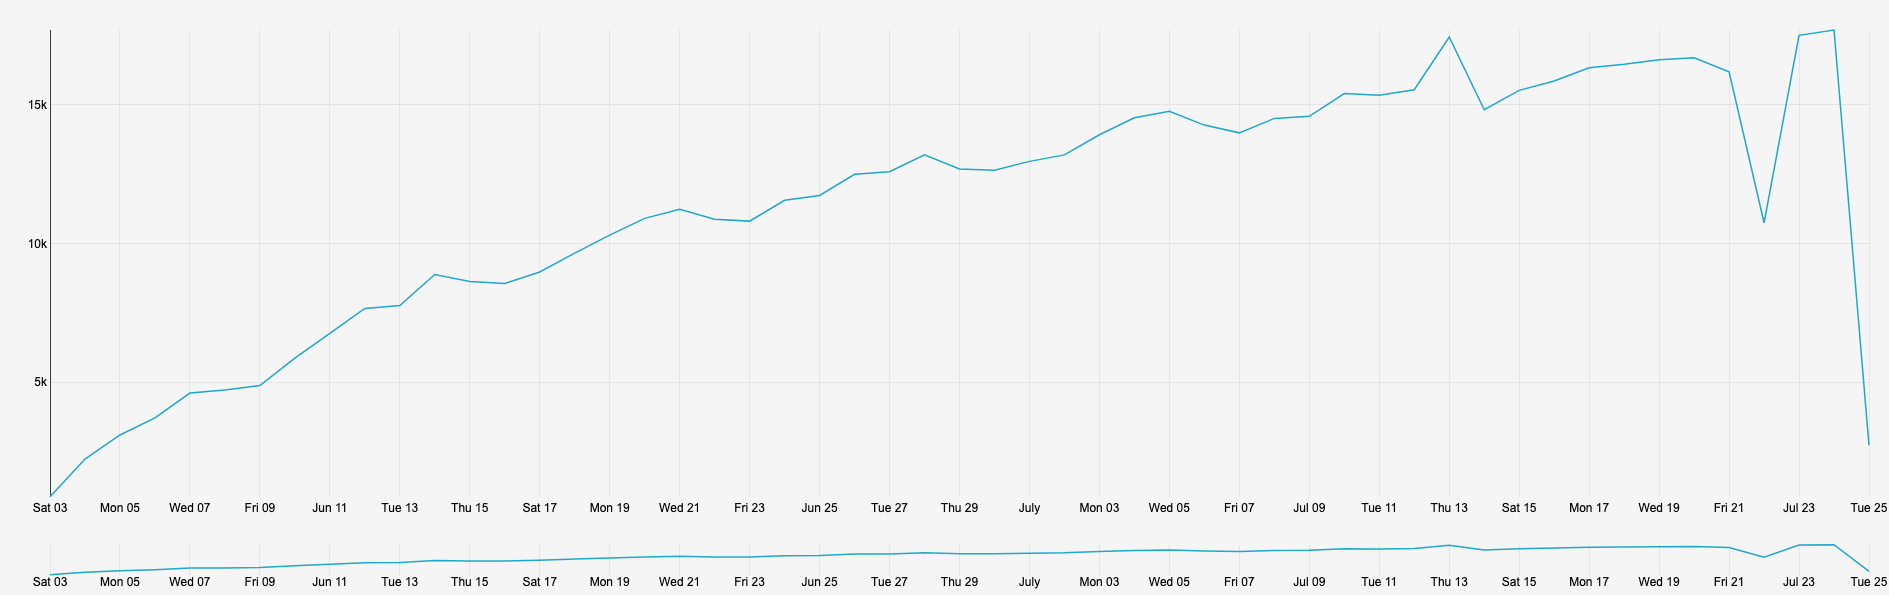

In [78]:
# get the data for active users on 22 July (drop) and 23 July (after the drop)
query = '''
-- users present after and NOT on drop date
WITH lost_on_drop AS (

SELECT DISTINCT user_id FROM {db}.feed_actions WHERE toDate(time) = '2023-07-23'::DATE
EXCEPT
SELECT DISTINCT user_id FROM {db}.feed_actions WHERE toDate(time) = '2023-07-22'::DATE
),

-- users present on drop date
stayed_on_drop AS (

SELECT DISTINCT user_id FROM {db}.feed_actions WHERE toDate(time) = '2023-07-22'::DATE
),

-- users classified by drop presence with their data, start date, and likes/views by day
users_classified_with_start_date AS (

SELECT *
   FROM
     (SELECT user_id,
             min(toDate(time)) AS start_day, 
             gender, 
             os, 
             country, 
             city,
             source,
             multiIf(age <= 16, '0-15', age > 16 and age <= 30, '16-30', age > 30 and age <= 55, '30-55', '55+') AS age_group
      FROM {db}.feed_actions
      GROUP BY user_id,
      gender, 
             os, 
             country,
             city,
             age_group,
             source
             ) t1
   JOIN
     (SELECT user_id,
     countIf(user_id, action = 'like') AS likes,
     countIf(user_id, action = 'view') AS views,
     toDate(time) AS day
      FROM {db}.feed_actions
      WHERE (toDate(time) = '2023-07-23'::DATE AND user_id IN (SELECT * FROM lost_on_drop))
      OR (toDate(time) = '2023-07-22'::DATE AND user_id IN (SELECT * FROM stayed_on_drop))
      GROUP BY user_id, day) t2 USING user_id
)

SELECT user_id,
if(day='2023-07-23'::DATE, 'control', 'on_drop') AS group,
likes,
views,
toString(start_day) AS start_day,
gender, 
os, 
country, 
city,
age_group,
source
FROM users_classified_with_start_date 
WHERE toString(day) != start_day 
'''

# import a table to a dataframe
users_by_drop = ph.read_clickhouse(
    query, 
    connection=CONNECTION
) 


In [80]:
users_by_drop.info()
users_by_drop.head(1)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23447 entries, 0 to 23446
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    23447 non-null  uint32
 1   group      23447 non-null  object
 2   likes      23447 non-null  uint64
 3   views      23447 non-null  uint64
 4   start_day  23447 non-null  object
 5   gender     23447 non-null  int8  
 6   os         23447 non-null  object
 7   country    23447 non-null  object
 8   city       23447 non-null  object
 9   age_group  23447 non-null  object
 10  source     23447 non-null  object
dtypes: int8(1), object(7), uint32(1), uint64(2)
memory usage: 1.7+ MB


,user_id,group,likes,views,start_day,gender,os,country,city,age_group,source
0,135426,control,5,37,2023-07-01,1,iOS,Germany,Berlin,16-30,organic


#### 1. Compare users activity, gender, OS type, source

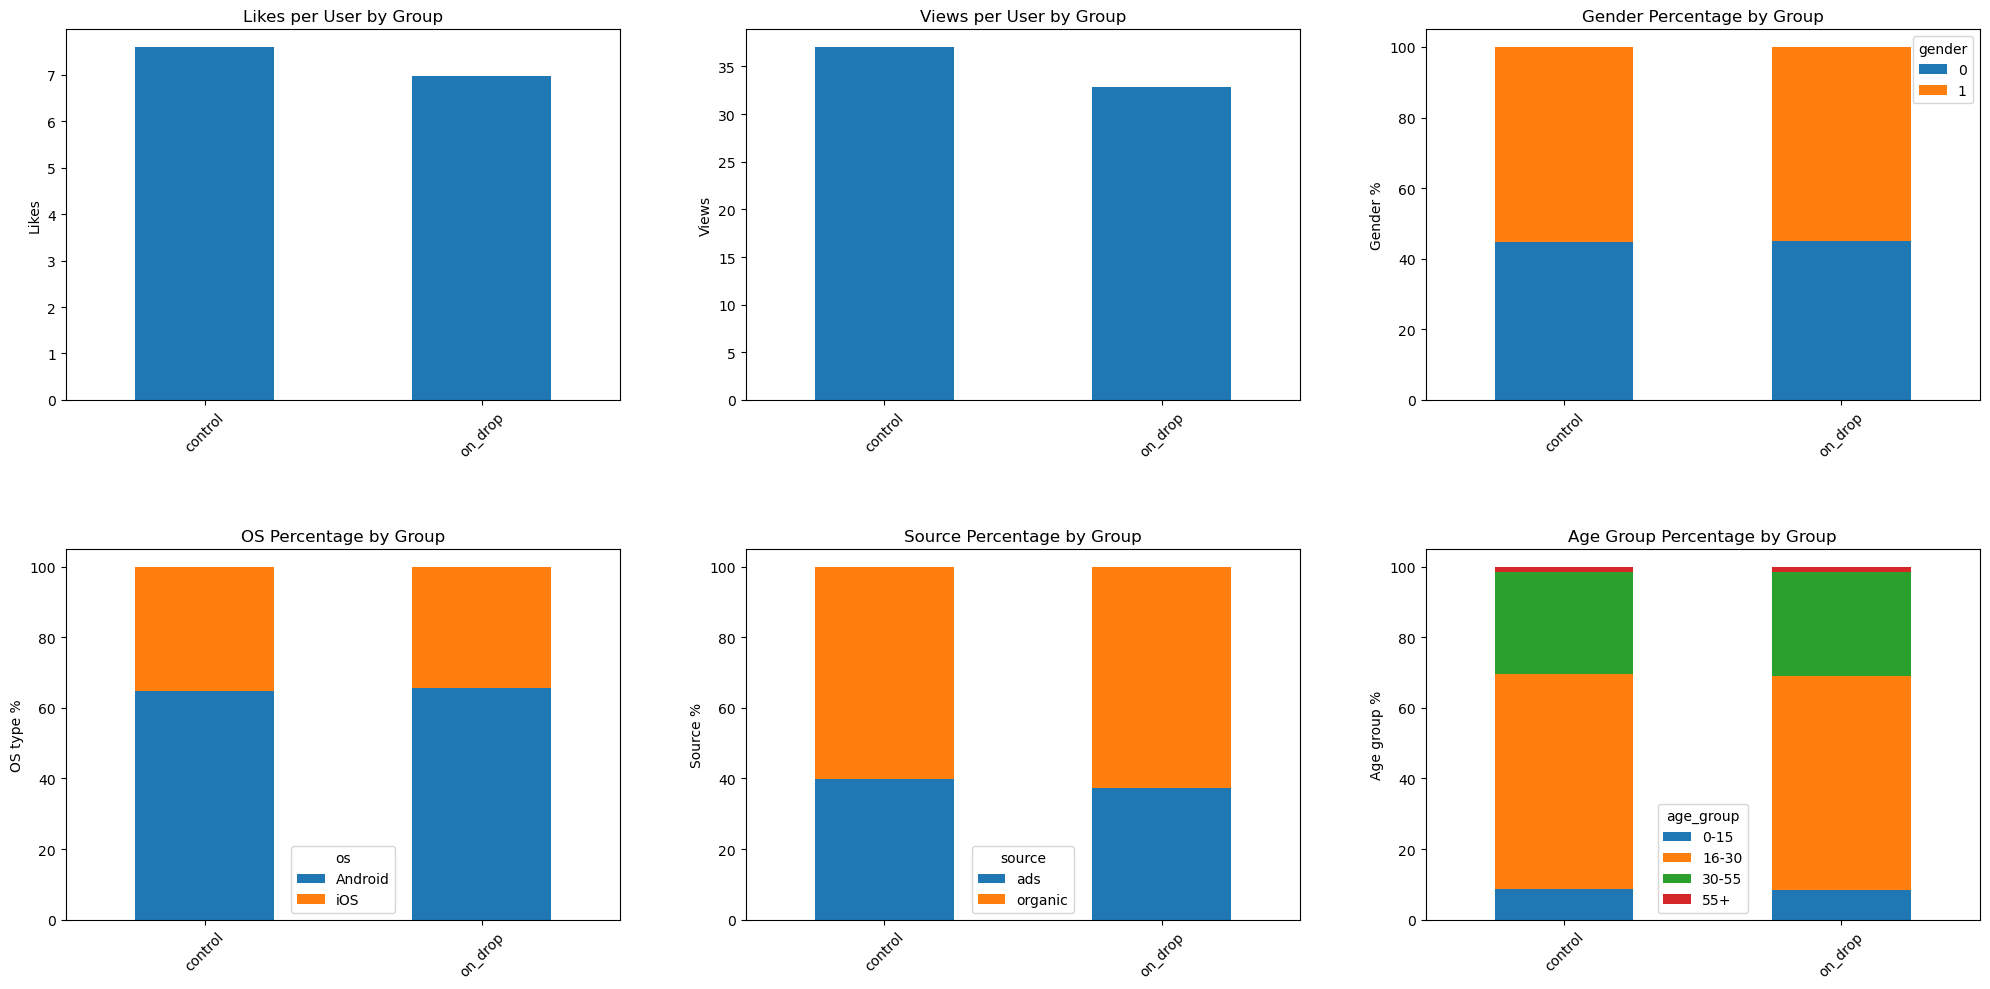

In [82]:
# Let's look at various metrics in between the two groups: on drop (target) and after the drop (control)
# Create a figure and subplot layout
fig, axs = plt.subplots(2, 3, figsize=(20,10))

# Plot 1 - Likes per User by Group
# group by group type, calculate the sum of likes within the group, and divide by number of users within the group
likes_per_user = users_by_drop.groupby("group")["likes"].sum() / users_by_drop.groupby("group")["user_id"].count()
barplotter(likes_per_user, "Likes per User by Group", "", "Likes", axs[0, 0], stacked=False)

# Plot 2 - Views per User by Group
views_per_user = users_by_drop.groupby("group")["views"].sum() / users_by_drop.groupby("group")["user_id"].count()
barplotter(views_per_user, "Views per User by Group", "", "Views", axs[0, 1], stacked=False)

# Plot 3 - Percentage of 0 and 1 in Gender by Group
gender_percentage = users_by_drop.groupby(["group", "gender"])["user_id"].count() / users_by_drop.groupby("group")["user_id"].count() * 100
barplotter(gender_percentage, "Gender Percentage by Group", "", "Gender %", axs[0, 2], stacked=True)

# Plot 4 - Percentage of Android and iOS in OS by Group
os_percentage = users_by_drop.groupby(["group", "os"])["user_id"].count() / users_by_drop.groupby("group")["user_id"].count() * 100
barplotter(os_percentage, "OS Percentage by Group", "", "OS type %", axs[1, 0], stacked=True)

# Plot 5 - Percentage of ads and organic in Source by Group
source_percentage = users_by_drop.groupby(["group", "source"])["user_id"].count() / users_by_drop.groupby("group")["user_id"].count() * 100
barplotter(source_percentage, "Source Percentage by Group", "", "Source %", axs[1, 1], stacked=True)

# Plot 6 - Percentage of Each Age Group by Group
age_group_percentage = users_by_drop.groupby(["group", "age_group"])["user_id"].count() / users_by_drop.groupby("group")["user_id"].count() * 100
barplotter(age_group_percentage, "Age Group Percentage by Group", "", "Age group %", axs[1, 2], stacked=True)

# Adjust layout and show the plots
plt.tight_layout(w_pad=5, h_pad=5)

# Show the plot
plt.show()


- users who likely were absent of the drop day and users that were present that day, do not seem to differ much by OS type (excludes OS-related bugs) and source (end of free subscriptions?)

- This excludes the possibility of OS-related bugs and end of free subscriptions issues.

Let's have a look at more metrics: starting day, country, city of the user.

#### 2. Compare day of start, country, city

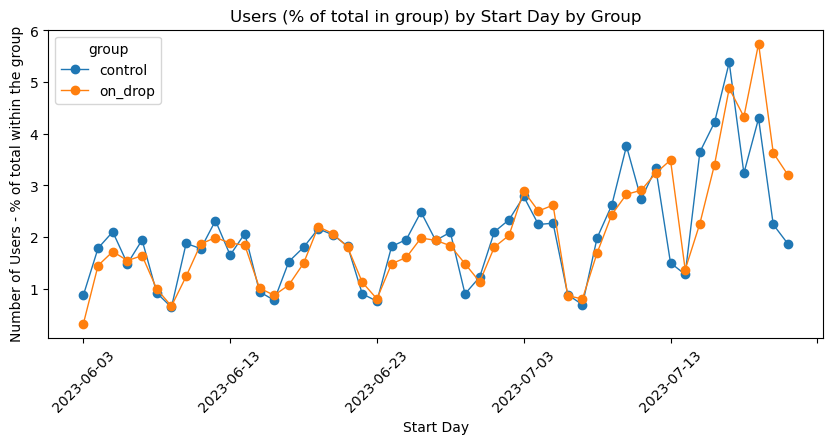

In [85]:
# Compare starting day pattterns for the groups
# Create a figure and axis, set font size
fig, ax = plt.subplots(figsize=(10, 4))

# aggregate by group and starting day, count the users, 
# find the total amount of users per group 
# and normalize counts on every day by it
normalizer = users_by_drop.groupby(["group", "start_day"])["user_id"].count().unstack().T.sum()
new = users_by_drop.groupby(["group", "start_day"])["user_id"].count().unstack().T * 100 / normalizer
new.plot(ax=ax, marker='o', linestyle='-', markersize=6, linewidth=1)

# Set plot properties
plt.title("Users (% of total in group) by Start Day by Group")
plt.xlabel("Start Day")
plt.ylabel("Number of Users - % of total within the group")

ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='y', rotation=0)

plt.show()

No difference. Last steps - see the composition by countries/cities - any difference between the groups?

In [86]:
# this time, similarly aggregate by the group and the country
# and see contribution of every country for each group
number_by_group_country = users_by_drop.groupby(["group", "country"])["user_id"].count().unstack().T.sort_values(by="control", ascending=False)
total_in_group = users_by_drop.groupby("group")["user_id"].count()

number_by_group_country = number_by_group_country.div(total_in_group).mul(100)
number_by_group_country['delta'] = number_by_group_country.on_drop.sub(number_by_group_country.control)

number_by_group_country.sort_values(by='delta')

group,control,on_drop,delta
country,,,
Germany,87.822170,84.857741,-2.964429
Switzerland,0.108433,0.113458,0.005025
Estonia,0.075069,0.087275,0.012206
Latvia,0.083410,0.113458,0.030048
Cyprus,0.083410,0.122185,0.038776
Finland,1.101009,1.143306,0.042297
Azerbaijan,0.984236,1.073486,0.089250
Belarus,2.118609,2.321522,0.202913
Turkey,0.984236,1.291674,0.307438


On a drop day, we had less users from certain countries - the drop is not uniform. Could be that there was region-specific issues with the access to the feed.  
Finally, let's look at the cities and their contribution. Is there any non-uniformity in drop there?

In [87]:
# this time, similarly aggregate by the group and the city
# and see contribution of every city for each group

# right part of the join, keeps info how may users from each group and city were active on respective day
number_by_group_city_right = users_by_drop.groupby(["group", "city"])["user_id"].count().unstack().T.sort_values(by="control", ascending=False)
total_in_group = users_by_drop.groupby("group")["user_id"].count()

# left part of the join, has no NaN entries, has normalized contribution of each city for each group
number_by_group_city_normalized = (number_by_group_city_right * 100 / total_in_group).dropna()
number_by_group_city_normalized['delta_relative'] = number_by_group_city_normalized.on_drop.sub(number_by_group_city_normalized.control)

# look at the entries where difference in percentage exceeds .1%
condition = np.abs(number_by_group_city_normalized.delta_relative) > 0.1

# filter the left table by the above condition
number_by_group_city_normalized = number_by_group_city_normalized.loc[condition]

# rename the columns with percentages
name_dict = {name: name + '_relative' for name in number_by_group_city_right.columns}
number_by_group_city_normalized.rename(columns=name_dict, inplace=True)

# do the join of the tables with absolute and relative contributions
number_by_group_city = number_by_group_city_normalized.join(number_by_group_city_right, how='left', on='city')

# make the delta column with the absolute difference in contribution
number_by_group_city['delta'] = number_by_group_city.on_drop.sub(number_by_group_city.control)

# sort the table by absolute difference
number_by_group_city.sort_values(by='delta', inplace=True)


In [88]:
number_by_group_city

group,control_relative,on_drop_relative,delta_relative,control,on_drop,delta
city,,,,,,
Minsk,0.784052,0.549834,-0.234218,94.0,63.0,-31.0
Vologda,0.250229,0.357829,0.107599,30.0,41.0,11.0
Augsburg,0.392026,0.506197,0.114171,47.0,58.0,11.0
Karlsruhe,0.558846,0.680747,0.121901,67.0,78.0,11.0
Oldenburg,0.325298,0.436376,0.111078,39.0,50.0,11.0
Taganrog,0.183502,0.288008,0.104507,22.0,33.0,11.0
Orsk,0.091751,0.192006,0.100255,11.0,22.0,11.0
Saransk,0.250229,0.366556,0.116327,30.0,42.0,12.0
Podolsk,0.200184,0.314191,0.114007,24.0,36.0,12.0


#### 3. Summary
- Type of OS, gender, age composition are not different between the groups, excluding the possibility of, for instance, OS-specific app bugs.  

- However, there seem to be regional bias in user amount on the drop day: some countries lost more users, which may be due to the region-specific behaviour of the product application.